In [1]:
!nvidia-smi
!pip install pandas
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from scipy.io import arff


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Wed Sep  4 06:27:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [3]:
!gdown --id 14SLk-7tkqwvewhzC9ffmWcsq387IcDaq
model = torch.load('model.pth')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14SLk-7tkqwvewhzC9ffmWcsq387IcDaq
To: /content/model.pth
100% 3.97M/3.97M [00:00<00:00, 252MB/s]


<ipython-input-3-bf802a5bb1ac>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')


In [4]:
!gdown --id 1i0T9horNTjAjf4fw1aL3BkNpS-FoEFVG
model_RNT = torch.load('model_RNT.pth')
model_RNT = model_RNT.to(device)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1i0T9horNTjAjf4fw1aL3BkNpS-FoEFVG
To: /content/model_RNT.pth
100% 3.97M/3.97M [00:00<00:00, 216MB/s]


<ipython-input-4-24f998a961a4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_RNT = torch.load('model_RNT.pth')


In [5]:
!gdown --id 1UYy2skQ0Z2ITZQrui6waFSxR3eFsf0jL
model_PVC = torch.load('model_PVC.pth')
model_PVC = model_PVC.to(device)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UYy2skQ0Z2ITZQrui6waFSxR3eFsf0jL
To: /content/model_PVC.pth
100% 3.97M/3.97M [00:00<00:00, 220MB/s]


<ipython-input-5-99af9d97a4a9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_PVC = torch.load('model_PVC.pth')


In [6]:
!gdown --id 1xIsKx_R1SzN4kniKzu2HrgT3FJrxwTJh
model_SP = torch.load('model_SP.pth')
model_SP = model_SP.to(device)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xIsKx_R1SzN4kniKzu2HrgT3FJrxwTJh
To: /content/model_SP.pth
100% 3.97M/3.97M [00:00<00:00, 230MB/s]


<ipython-input-6-e9009a4bb96e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_SP = torch.load('model_SP.pth')


In [7]:
!gdown --id 1rrr06bD_esk2eTe7hX3NjZqQFgBf-dlq

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rrr06bD_esk2eTe7hX3NjZqQFgBf-dlq
To: /content/output_excel_file.xlsx
100% 8.25k/8.25k [00:00<00:00, 35.3MB/s]


In [8]:
df=pd.read_excel("output_excel_file.xlsx")

In [9]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features
dataset, seq_len, n_features = create_dataset(df)

In [10]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [11]:
def plot_prediction(data, model, title):
  predictions, pred_losses = predict(model, [data])

  plt.plot(data, label='true')
  plt.plot(predictions[0], label='reconstructed')
  plt.legend()


In [12]:
_, losses_normal = predict(model, dataset)
losses_normal

[6.144691467285156]

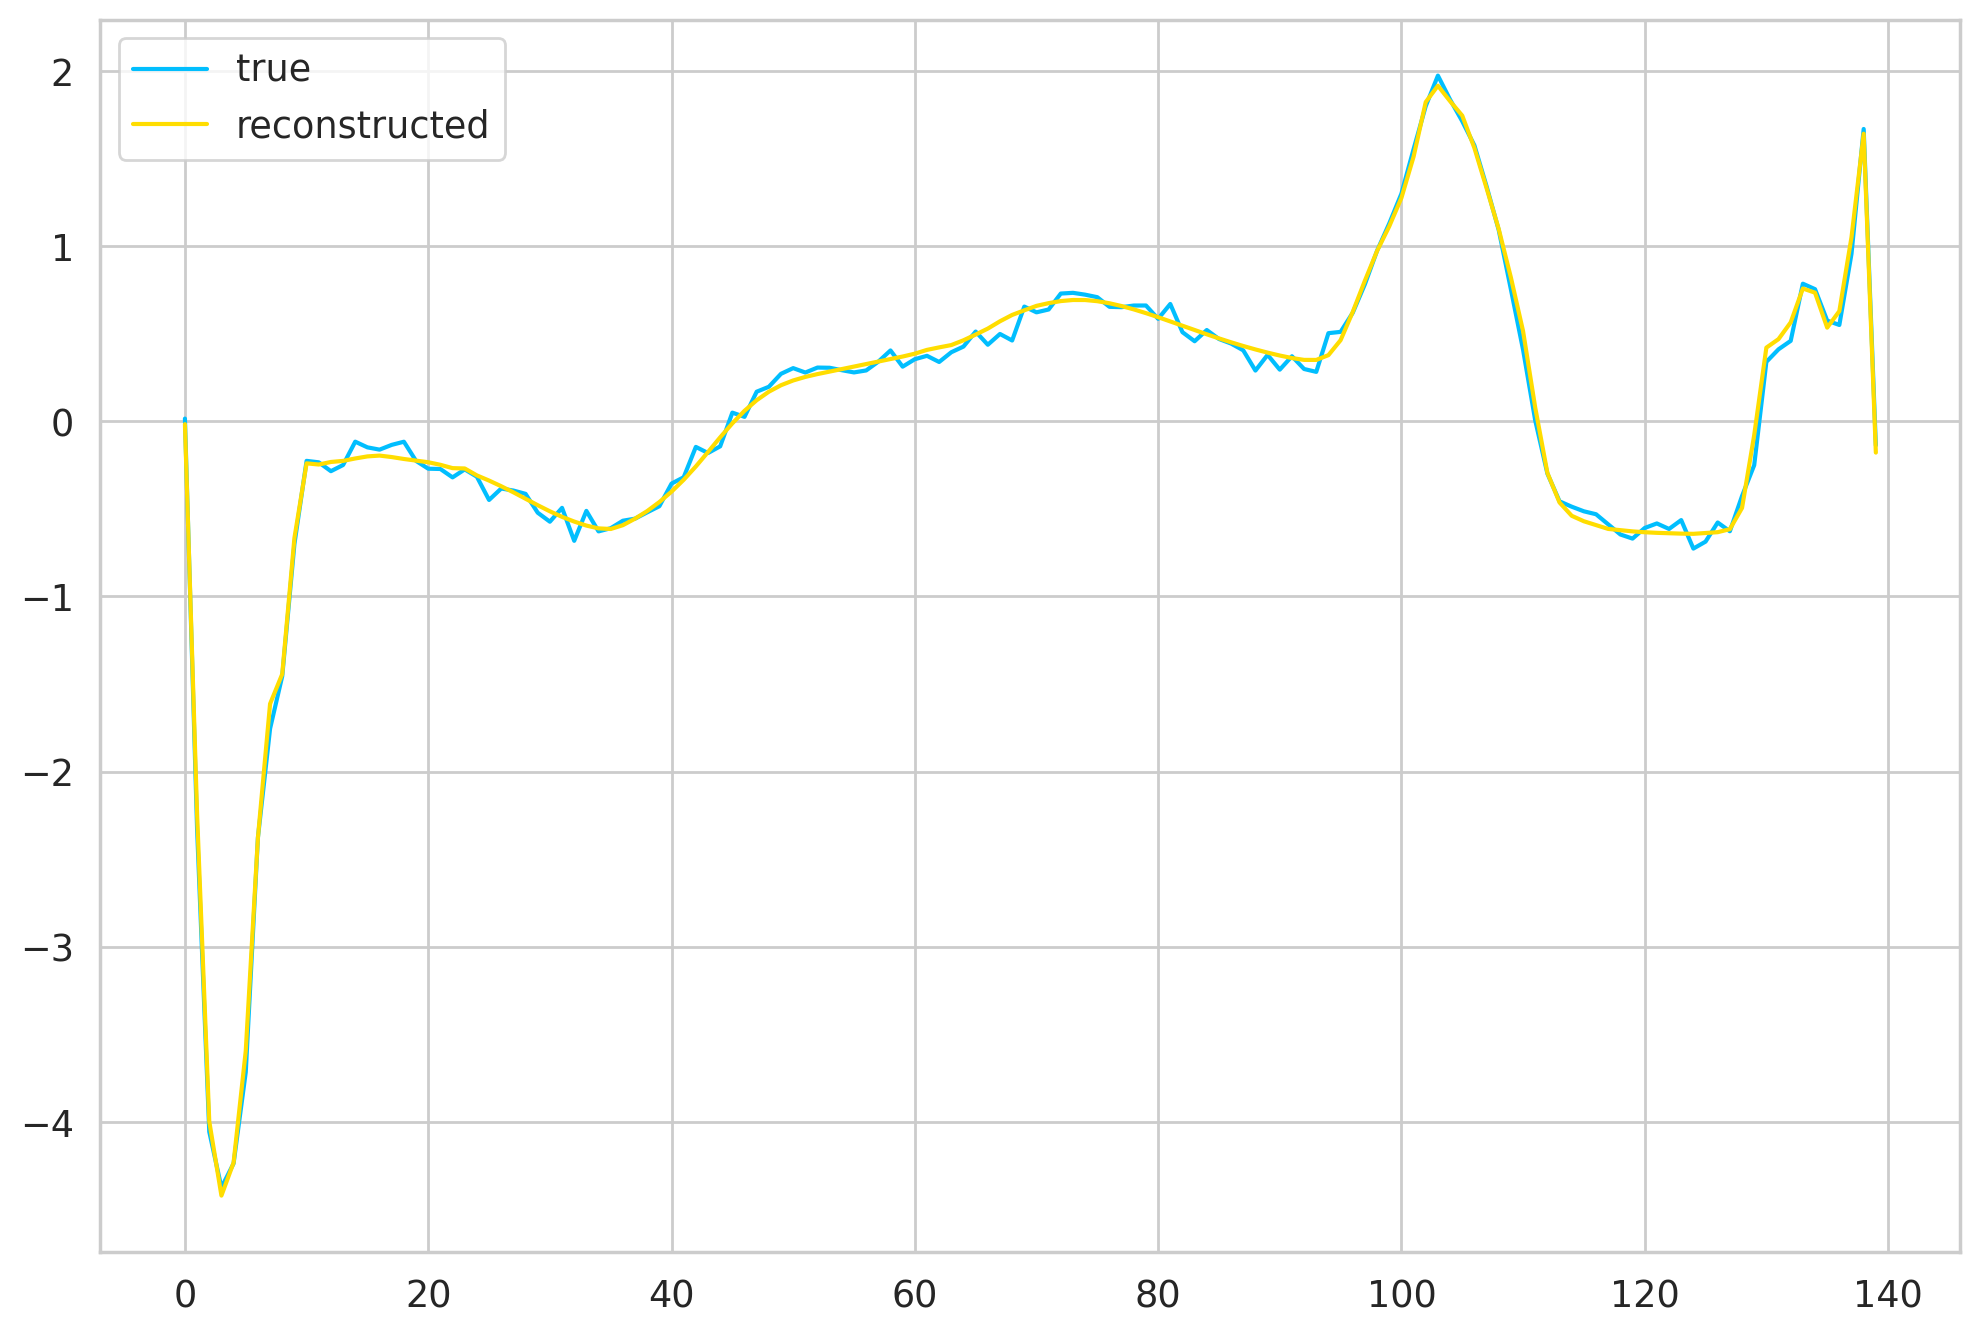

In [13]:
for idx,input_data in enumerate(dataset[:1]):
  plot_prediction(input_data, model, title='Normal')

In [14]:
_, losses_RNT = predict(model_RNT, dataset)
losses_RNT

[57.571998596191406]

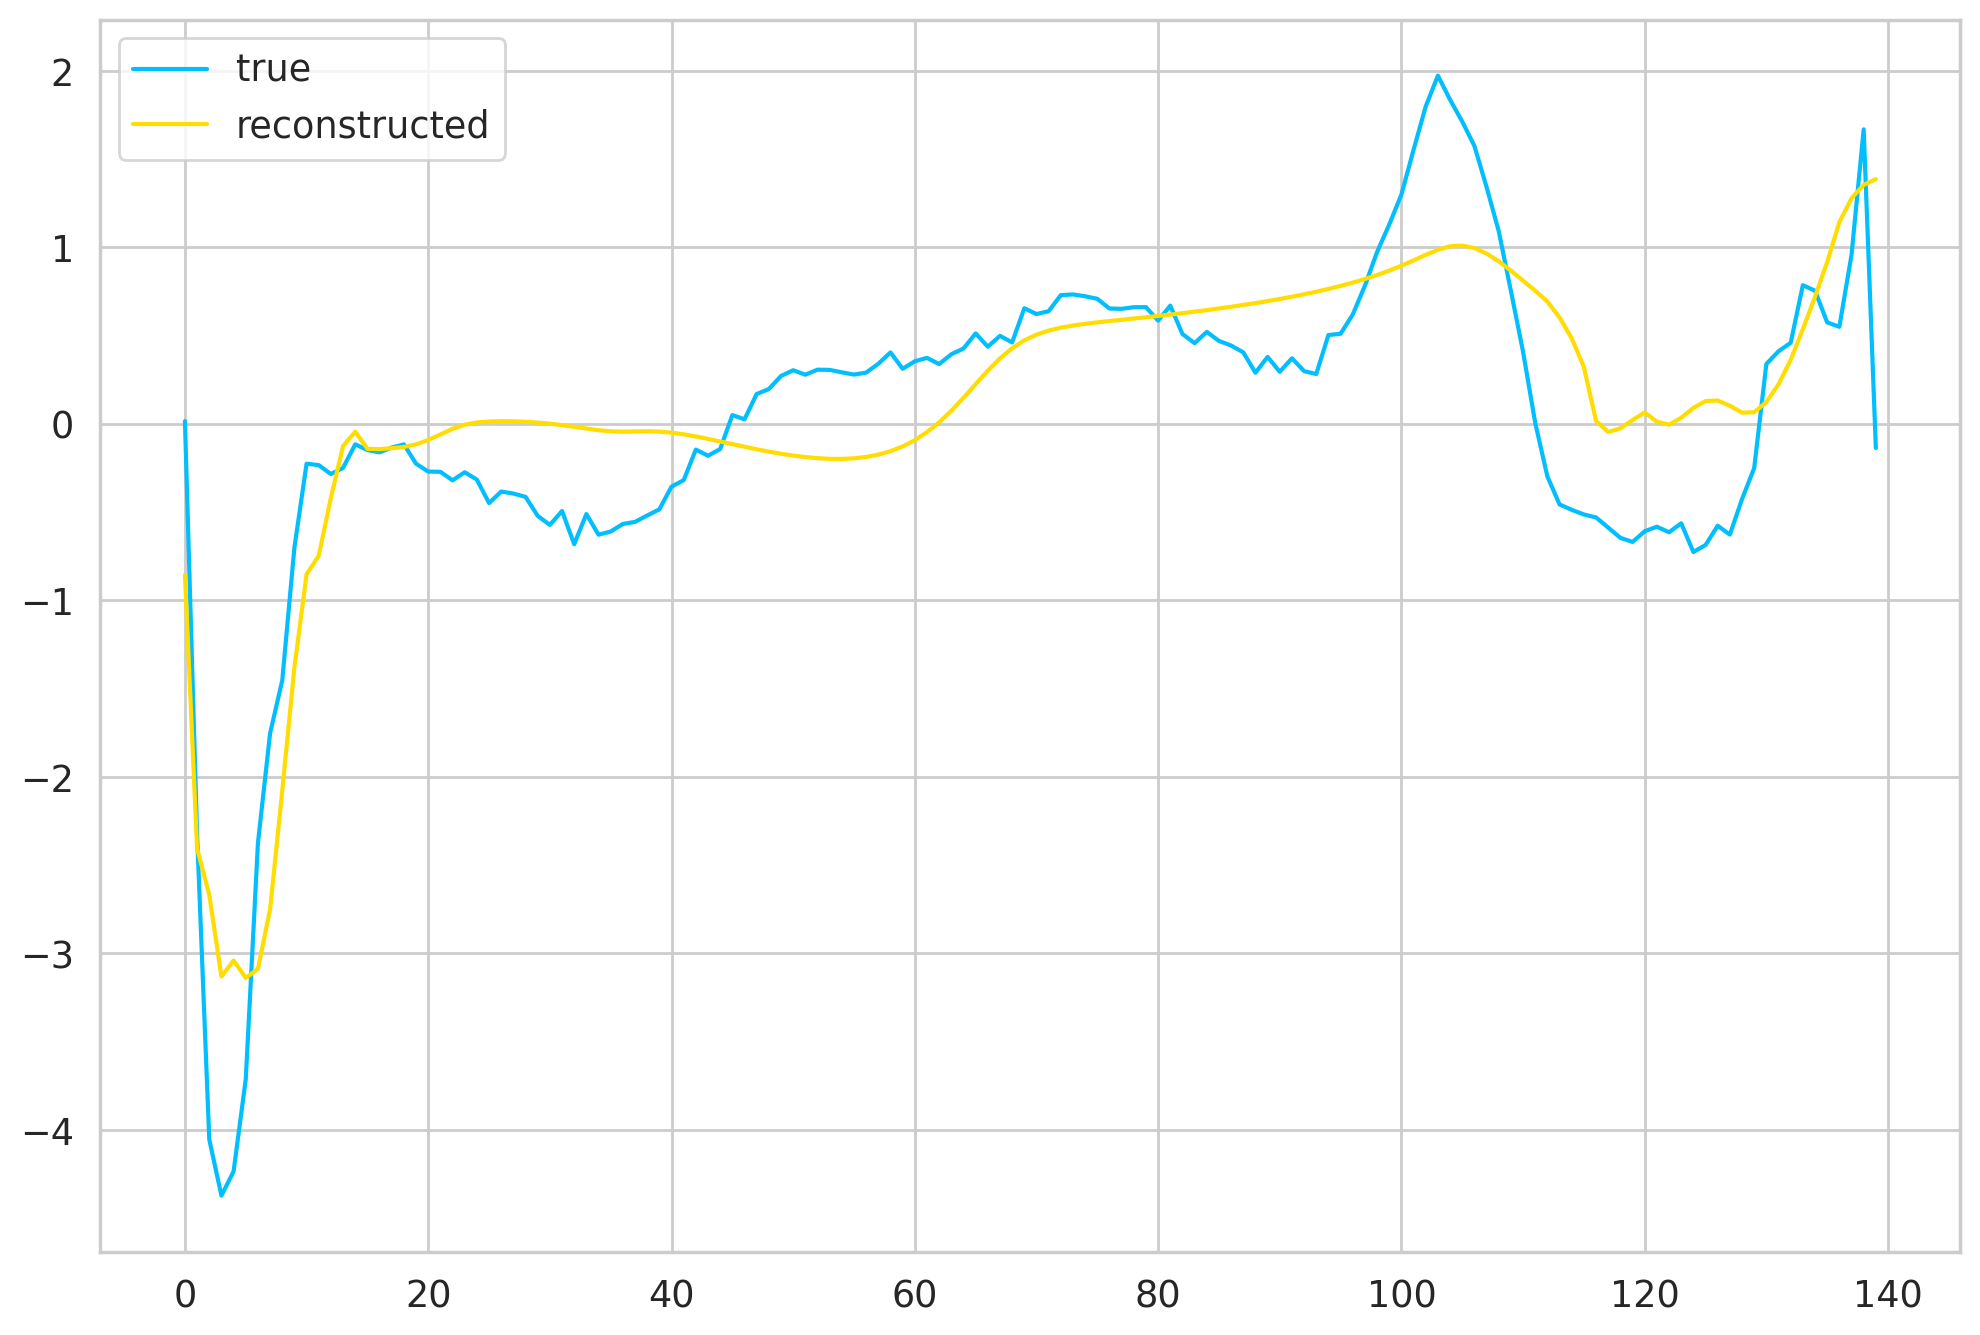

In [15]:
for idx,input_data in enumerate(dataset[:1]):
  plot_prediction(input_data, model_RNT, title='Normal')

In [16]:
_, losses_PVC = predict(model_PVC, dataset)
losses_PVC

[55.12666320800781]

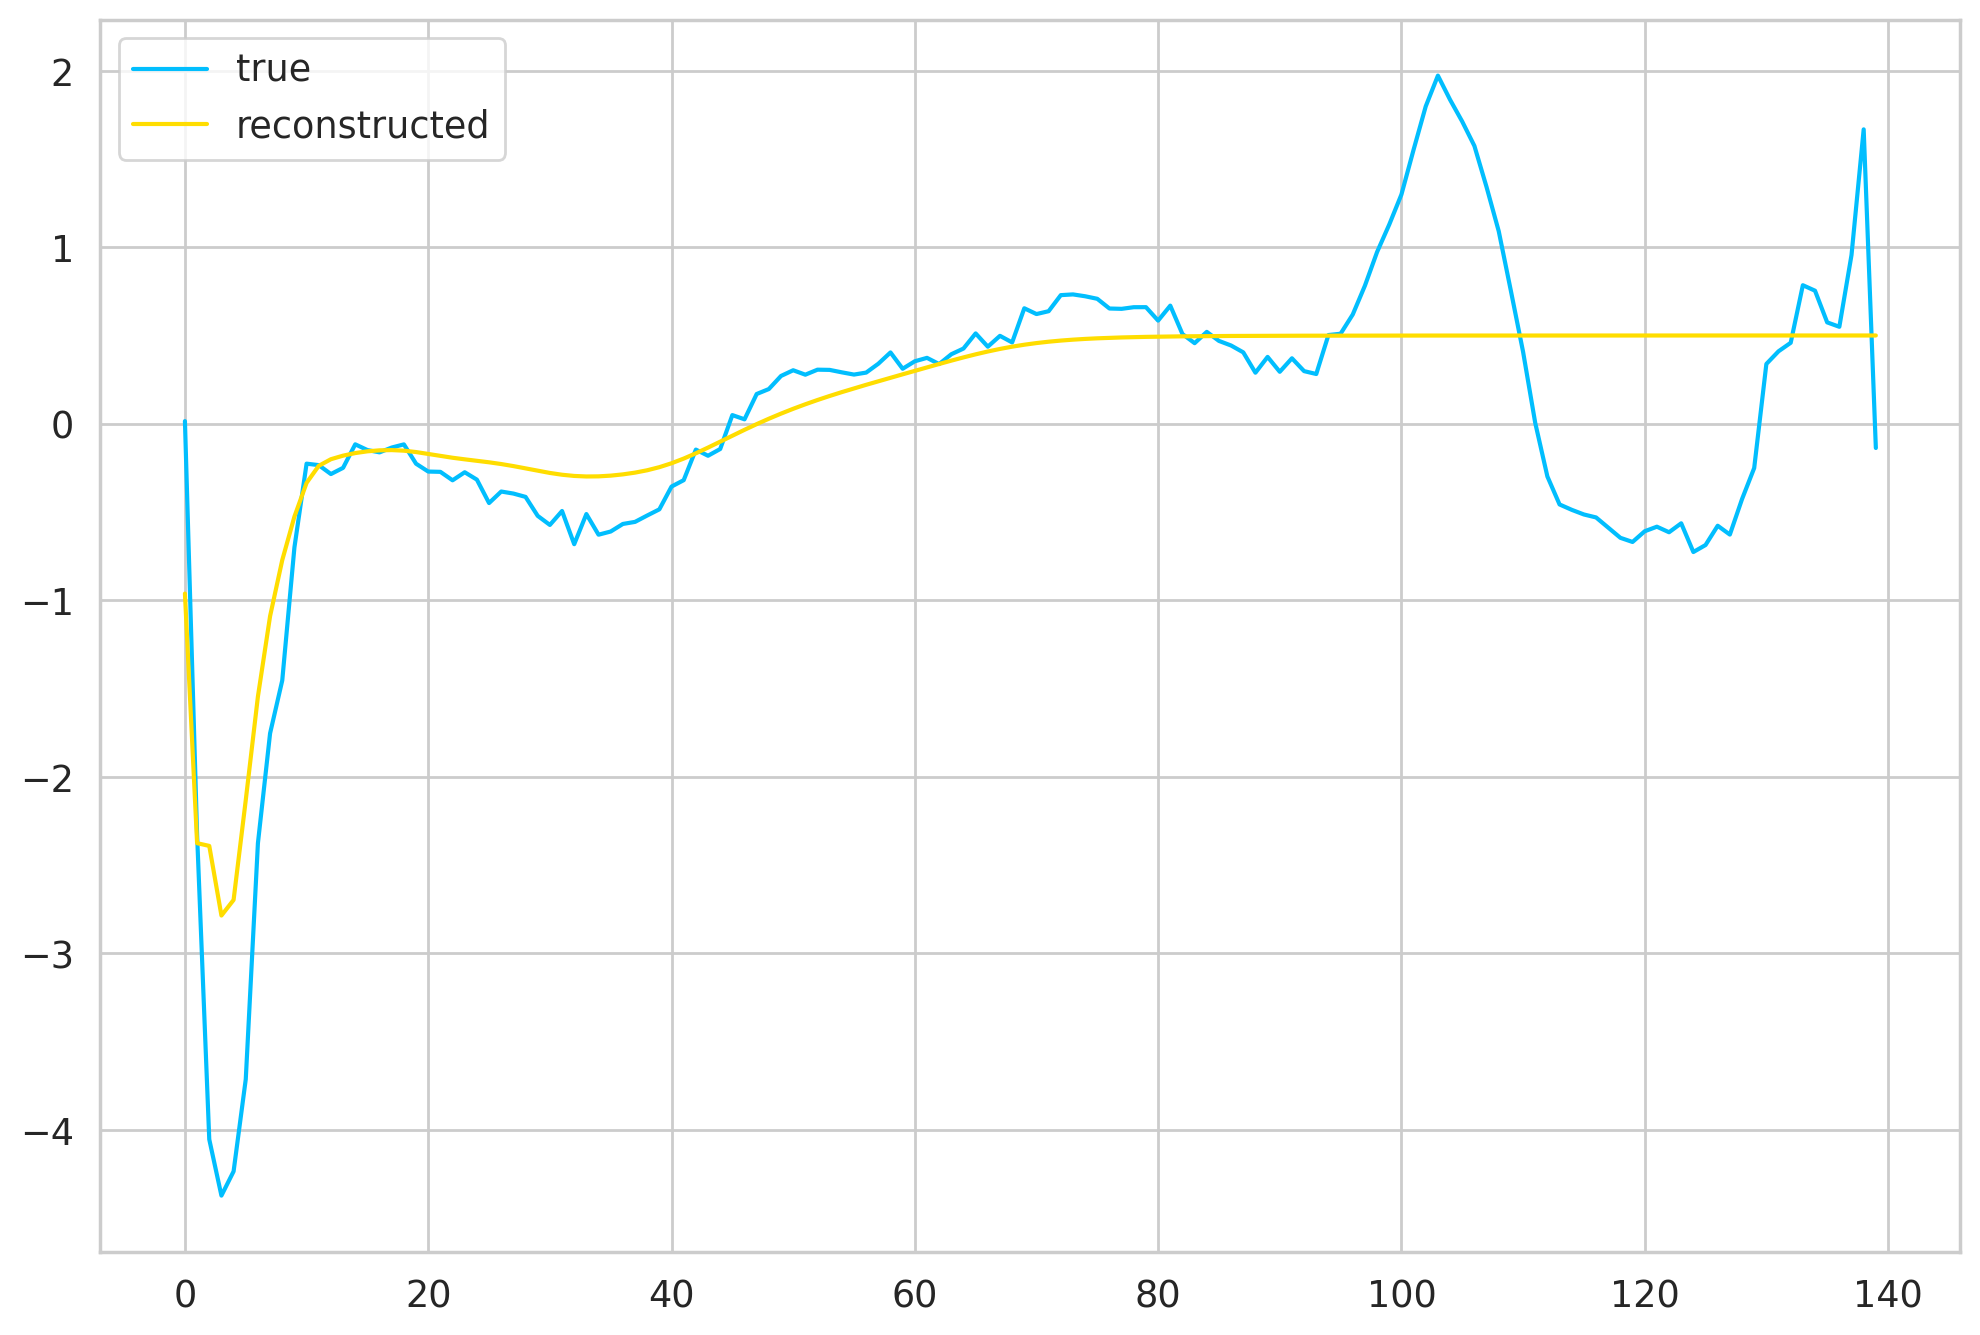

In [17]:
for idx,input_data in enumerate(dataset[:1]):
  plot_prediction(input_data, model_PVC, title='Normal')

In [18]:
_, losses_SP = predict(model_SP, dataset)
losses_SP

[69.90015411376953]

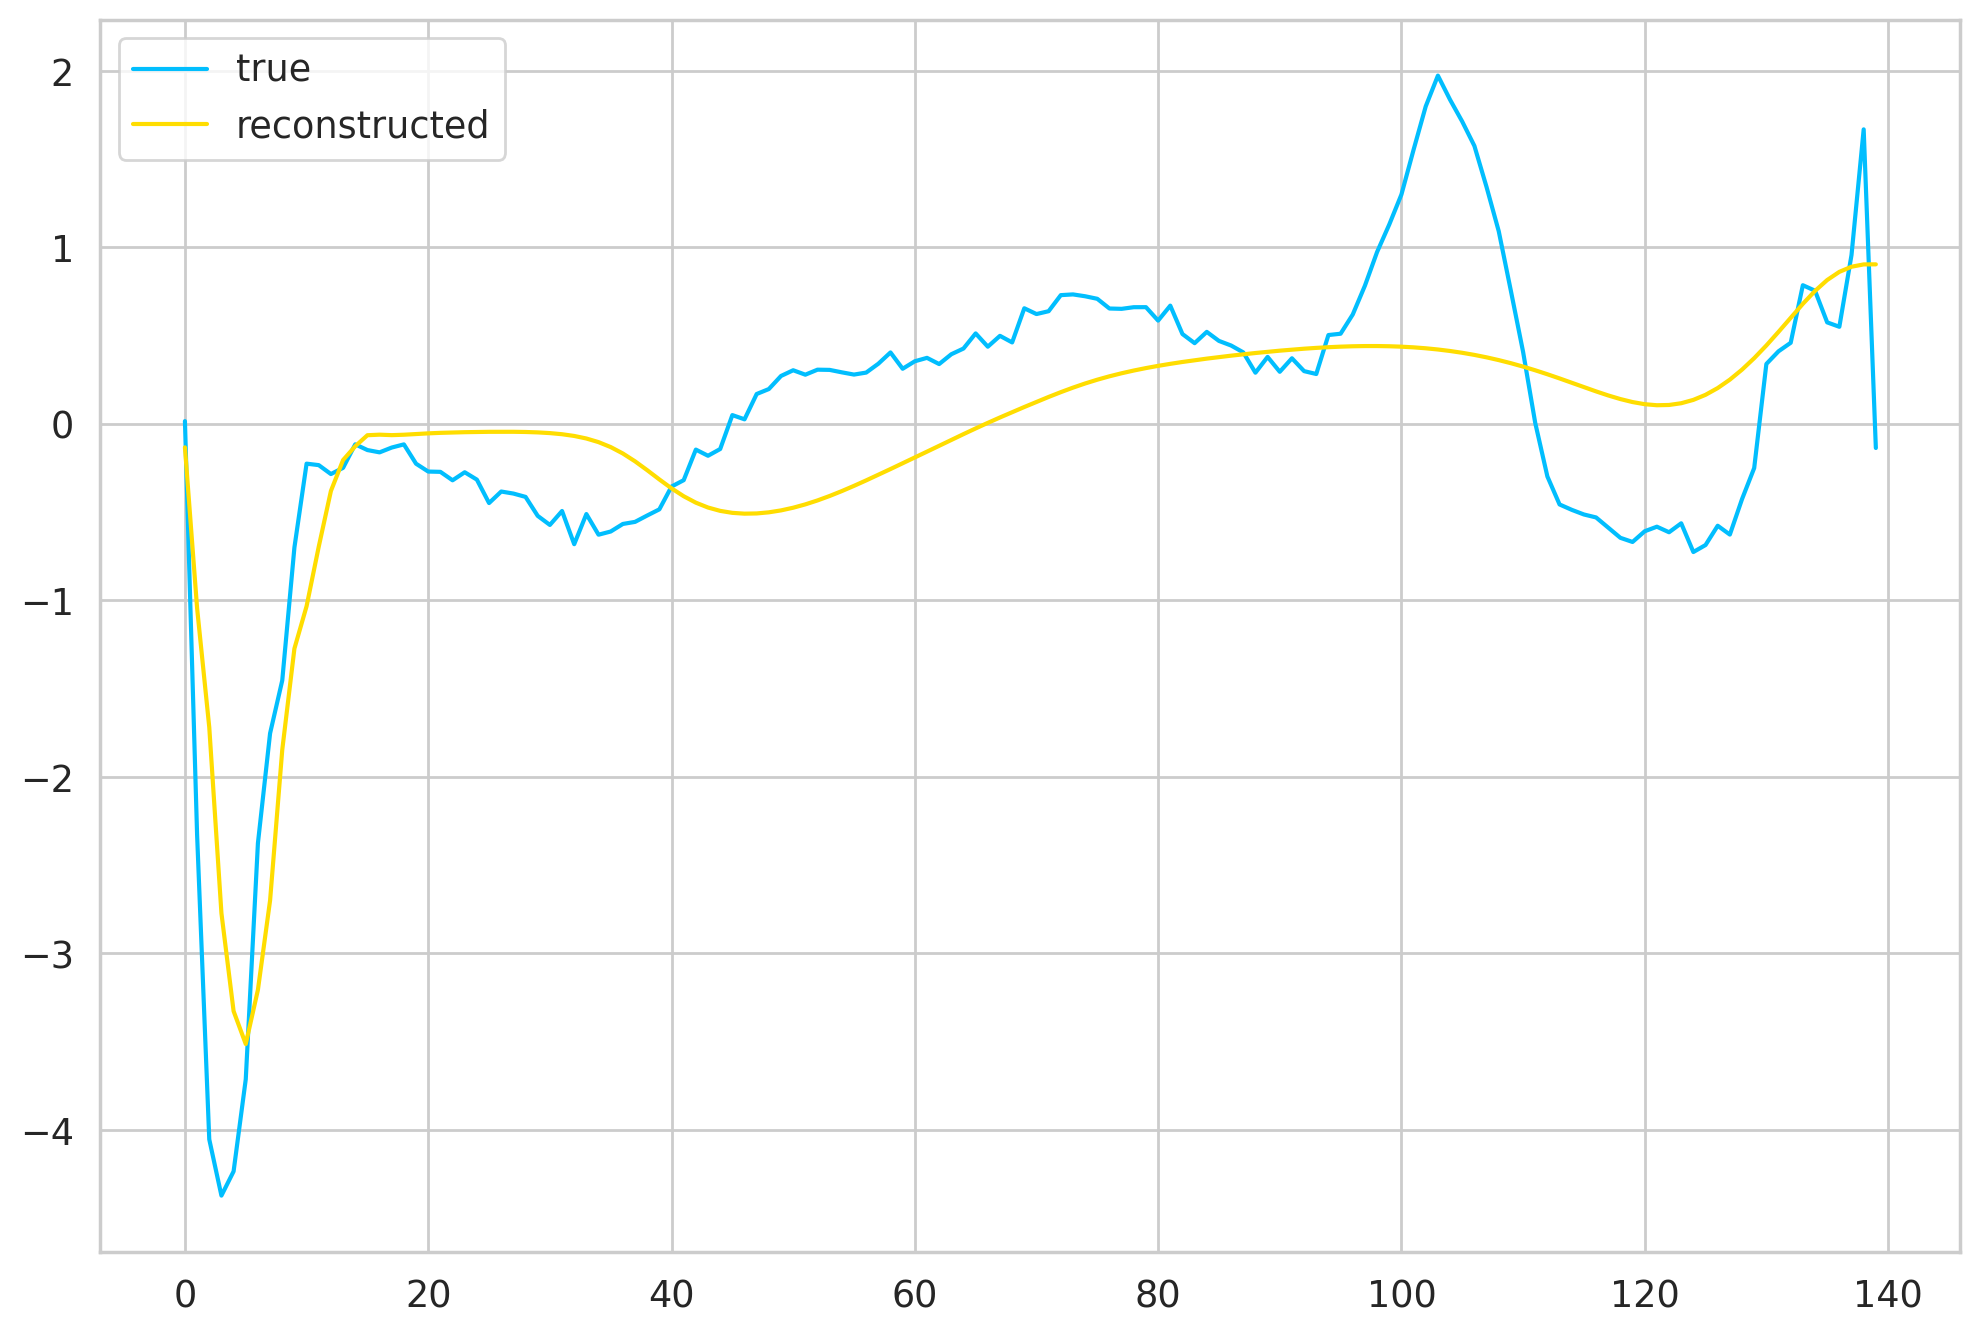

In [19]:
for idx,input_data in enumerate(dataset[:1]):
  plot_prediction(input_data, model_SP, title='Normal')

In [20]:
loss_normal=sum(losses_normal) / len(losses_normal)
loss_RNT=sum(losses_RNT) / len(losses_RNT)
loss_PVC=sum(losses_PVC) / len(losses_PVC)
loss_SP=sum(losses_SP) / len(losses_SP)

In [21]:
list=[loss_normal,loss_RNT,loss_PVC,loss_SP]
min_index, min_value = min(enumerate(list), key=lambda x: x[1])

print("Minimum value:", min_value)
print("Index of minimum value:", min_index)

Minimum value: 6.144691467285156
Index of minimum value: 0


In [22]:
if min_index==0:
  if min_value<26:
    print("Normal heartbeat")
  else:
      print("Model is unable to make a decision")
elif min_index==1:
  if min_value<36:
    print("R-on-T Premature Ventricular Contraction")
  else:
      print("Model is unable to make a decision")
elif min_index==2:
  if min_value<66:
    print("supposedly Premature Ventricular Contraction")
  else:
      print("Model is unable to make a decision")
elif min_index==3:
  if min_value<36:
    print("Supra-ventricular Premature or Ectopic Beat")
  else:
      print("Model is unable to make a decision")

Normal heartbeat
